In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
import scikitplot as skplt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

In [29]:
train_df = pickle.load(open('./proxy/traindataset02.bin','rb'))

In [30]:
test_df = pickle.load(open('./proxy/testdataset02.bin','rb'))

In [31]:
feature_names = [x for x in train_df.columns if x not in ['connection_id','target']]

In [32]:
target = train_df['target']

In [33]:
from sklearn.cross_validation import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_df[feature_names], target, train_size = 0.9, stratify = target, random_state = 2017)

In [8]:
from sklearn.metrics import accuracy_score
def multAcc(pred, dtrain):
    label = dtrain.get_label()
    acc = accuracy_score(label, pred)
    return 'maccuracy', acc

In [9]:
params = {'objective':'multi:softmax',
          'num_class':3,
          # 'eval_metric':'merror'
         }

In [10]:
import xgboost as xgb

In [11]:
dtrain = xgb.DMatrix(data=X_train[feature_names], label=y_train)
dvalid = xgb.DMatrix(data=X_test[feature_names], label=y_test)
dtest = xgb.DMatrix(data=test_df[feature_names])
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]

In [12]:
clf1 = xgb.train(params, dtrain, 1000, watchlist, maximize=True, verbose_eval=20, early_stopping_rounds=40, feval=multAcc)

[0]	train-maccuracy:0.777997	eval-maccuracy:0.777745
Multiple eval metrics have been passed: 'eval-maccuracy' will be used for early stopping.

Will train until eval-maccuracy hasn't improved in 40 rounds.
[20]	train-maccuracy:0.781685	eval-maccuracy:0.780285
[40]	train-maccuracy:0.782387	eval-maccuracy:0.780462
[60]	train-maccuracy:0.783234	eval-maccuracy:0.78058
[80]	train-maccuracy:0.784015	eval-maccuracy:0.780167
Stopping. Best iteration:
[47]	train-maccuracy:0.782774	eval-maccuracy:0.780757



In [27]:
pred = clf1.predict(dtest)

In [28]:
## make submission
sub = pd.read_csv('./input/sample_submission.csv')
sub['target'] = pred
sub['target'] = sub['target'].astype(int)
sub.to_csv('./output/sub1.csv', index=False)

In [57]:
from sklearn.metrics import f1_score

In [58]:
from sklearn.metrics import make_scorer

In [85]:
mll_scorer = make_scorer(f1_score)

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
param_grid = {'min_samples_split':[2,5],
             'min_samples_leaf':[1,2,5]}

In [92]:
clf = RandomForestClassifier(n_estimators=300,max_depth=15)

In [87]:
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=f1_score(average=None),
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

TypeError: f1_score() missing 2 required positional arguments: 'y_true' and 'y_pred'

In [93]:
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_feature_importances is deprecated; This will be removed in v0.4.0. Please use scikitplot.estimators.plot_feature_importances instead.
  warnings.warn(msg, category=DeprecationWarning)


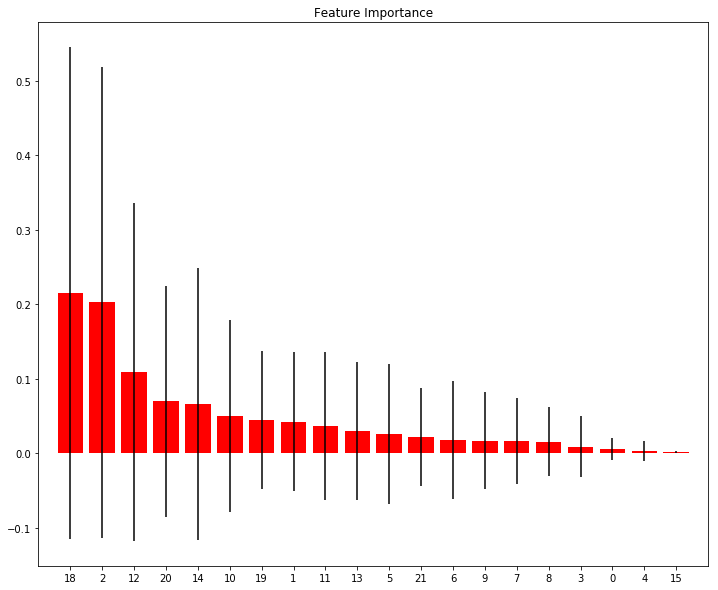

In [94]:
skplt.plotters.plot_feature_importances(clf)

In [95]:
plt.show()

In [66]:
pred = clf.predict(X_test)

In [67]:
tr_predict = clf.predict(X_train)

In [74]:
f1_score(y_train,tr_predict,average=None)

array([ 0.84270809,  0.99579908,  0.00696906])

In [72]:
f1_score(y_test,pred,average= None).mean()

0.61247821638438382

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


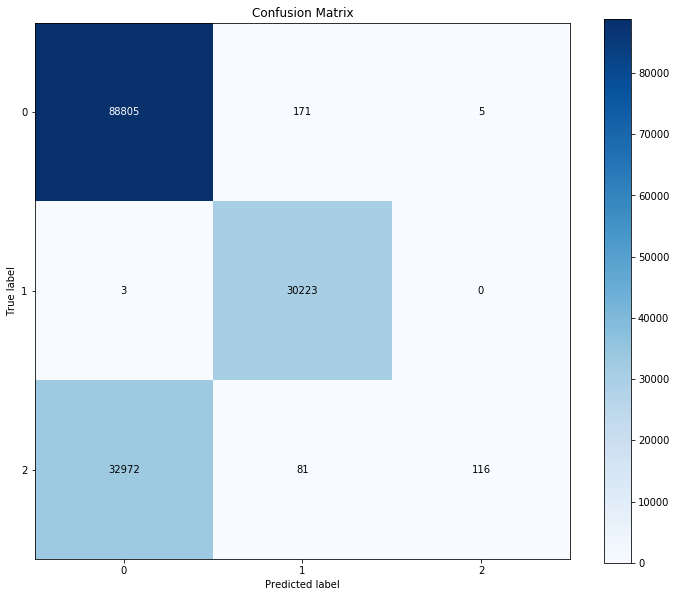

In [97]:
skplt.plotters.plot_confusion_matrix(y_train,tr_predict)

In [98]:
plt.show()

In [52]:
pred = clf.predict(test_df[feature_names])

In [53]:
sub = pd.read_csv('./input/sample_submission.csv')
sub['target'] = pred
sub['target'] = sub['target'].astype(int)
sub.to_csv('./output/sub2.csv', index=False)

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [72]:
param_grid = {'n_estimators':[100,120,150]}

In [77]:
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=5,min_samples_leaf=5,min_samples_split=8
                                  ,n_estimators=100)

In [74]:
model = GridSearchCV(estimator=clf1, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

In [79]:
clf1.fit(train_df[feature_names],target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=5,
              min_samples_split=8, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [80]:
pred_gb = clf.predict(test_df[feature_names])

In [81]:
sub = pd.read_csv('./input/sample_submission.csv')
sub['target'] = pred_gb
sub['target'] = sub['target'].astype(int)
sub.to_csv('./output/sub3.csv', index=False)

In [82]:
sub = pd.read_csv('./input/sample_submission.csv')
sub['target'] = pred_gb
sub['target'] = sub['target'].astype(int)
sub.to_csv('./output/ensemble.csv', index=False)

In [87]:
train_df['target'].value_counts()

0    98868
2    36854
1    33585
Name: target, dtype: int64

In [39]:
pred1 = clf1.predict(X_test)

In [40]:
tr_pred1 = clf1.predict(X_train)

In [41]:
accuracy_score(y_test,pred1)

0.78058000118126514

In [42]:
accuracy_score(y_train,tr_pred1)

0.78104819656638835

In [43]:
from sklearn.ensemble import ExtraTreesClassifier

In [44]:
clf2 = ExtraTreesClassifier()

In [45]:
clf2.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [46]:
pred2 = clf2.predict(X_test)
tr_pred2 = clf2.predict(X_train)

In [47]:
accuracy_score(y_test,pred2)

0.76427854231882342

In [48]:
accuracy_score(y_train,tr_pred2)

0.82169107996009871

In [49]:
from sklearn.ensemble import BaggingClassifier

In [50]:
clf3 = ExtraTreesClassifier()

In [53]:
clf3.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [54]:
pred3 = clf3.predict(X_test)
tr_pred3 = clf3.predict(X_train)

In [55]:
accuracy_score(y_test,pred3)

0.76510542791329517

In [56]:
accuracy_score(y_train,tr_pred3)

0.82169107996009871

In [62]:
import scikitplot as skplt

In [74]:
skplt.plotters.plot_feature_importances(clf1)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_feature_importances is deprecated; This will be removed in v0.4.0. Please use scikitplot.estimators.plot_feature_importances instead.
  warnings.warn(msg, category=DeprecationWarning)


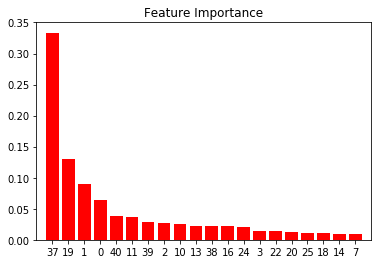

In [75]:
plt.show()

In [81]:
clf3.feature_importances_

array([  1.40866783e-03,   4.75875454e-03,   1.45535524e-02,
         2.01528827e-02,   4.92288136e-03,   1.68716479e-03,
         1.32356542e-02,   9.49714620e-02,   1.33688071e-02,
         2.57419998e-02,   5.05509136e-02,   2.44183879e-02,
         3.26317644e-02,   2.97119425e-03,   7.92682338e-03,
         5.09703256e-03,   3.49759485e-03,   2.53174523e-02,
         7.57458284e-02,   1.20290006e-02,   5.15808619e-03,
         3.70770893e-06,   4.42410864e-04,   0.00000000e+00,
         1.22687346e-03,   3.27177654e-04,   1.31314534e-01,
         5.07823615e-04,   4.82384271e-05,   8.43362462e-08,
         2.78190995e-05,   3.01369279e-05,   1.60906888e-05,
         4.85210620e-05,   0.00000000e+00,   2.40734935e-05,
         2.92772272e-04,   2.38137566e-01,   5.58005092e-02,
         1.10184760e-01,   2.14209963e-02])

In [83]:
skplt.plotters.plot_confusion_matrix(y_train,tr_pred3)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


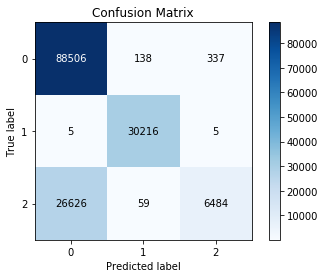

In [84]:
plt.show()

In [89]:
skplt.plotters.plot_learning_curve(clf3,X_train,y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_learning_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.estimators.plot_learning_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


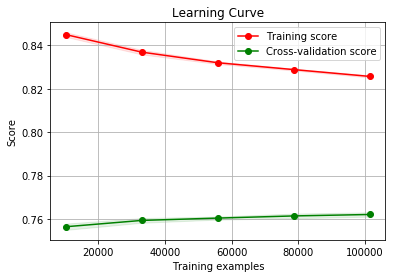

In [90]:
plt.show()